# Pattern Matching 4 - Video, Matching & Tracking

**Objectives**

* Analyze video sequences: background detection + background substraction
* Match objects between frames for tracking

## Video import

[Download](https://my.pcloud.com/publink/show?code=XZpIUMkZQX7lwSh8BPpO5vF6UWC6xSXgVLRy) the images from the video sequence (individual frame as jpeg), and the supervised segmentation ground truth (for some of the frames 2 sequences: binary mask + annotated fish): 

(Reference: http://groups.inf.ed.ac.uk/f4k/PAPERS/VIGTA2012.pdf)

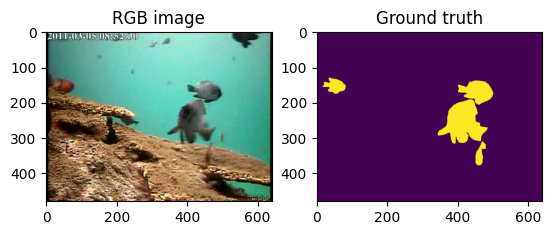

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
import os

# config
vid_path = 'data/video_data/Video/'
gt_path = 'data/video_data/GroundTruth/'

seq0 = [685,705]
seq1 = [1173,1191]

# display first frame of seq1
for no in range(*seq1):
    fid = os.path.join(vid_path,'frame%04d.jpg'%no)
    rgb = imread(fid)    
    
    fid =  os.path.join(gt_path,'%d.png'%no)
    supervision = imread(fid)
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('RGB image')
    plt.imshow(rgb)
    plt.subplot(1,2,2)
    plt.imshow(supervision)
    plt.title('Ground truth')
    break #stop after one frame for test purpose

## Background image (Video segmentation)

When analyzing video sequences, we can use the *movement of the frame* to help our object segmentation. In this video, our goal is to segment the fish from the background. The background here is the part of the image that doesn't change from frame to frame: detecting the objects can therefore be done using **background subtraction**.

Implement the background subtraction algorithm:

1. Initialize background image: $B_{0} = I_{0}$ where $I_t$ is the image at time $t$ and $B$ is the estimated background. 
1. Update background: $B_{t} = \alpha B_{t-1} + (1-\alpha) I_t$
> What is the purpose of $\alpha$? How can you determine that your background estimation is "stable" and can be used?
1. Subtract background to detect foreground: $F_t = I_t - B_t$
1. Find a good post-processing to clean-up the foreground image. Label the individual objects (fish).
1. Using the supervised part of the sequence, estimate the detection error of your algorithm.
> *Hint: useful metrics for segmentation performance include per-pixel accuracy, precision, recall, or F1-score (DICE). These measures can also be made per-object, which is slightly more difficult to compute but in many applications a better indicator of the actual performance of the algorithm.*

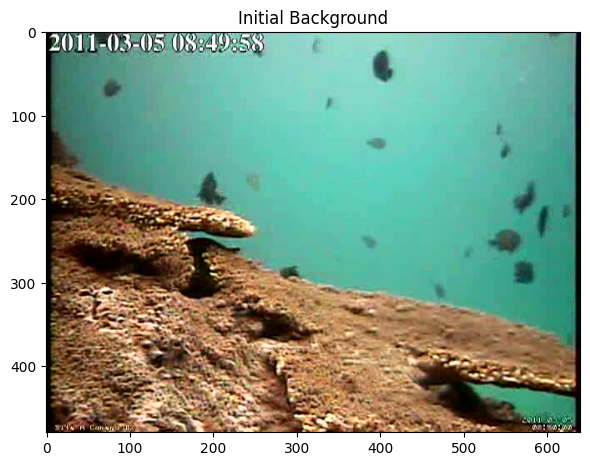

In [2]:
# build the first-frame filename and load it
B = imread(os.path.join(vid_path, 'frame%04d.jpg'%1))

# visualize initial background
plt.figure(figsize=(6, 6))
plt.imshow(B / 255.0)
plt.title("Initial Background")
plt.tight_layout()
plt.show()

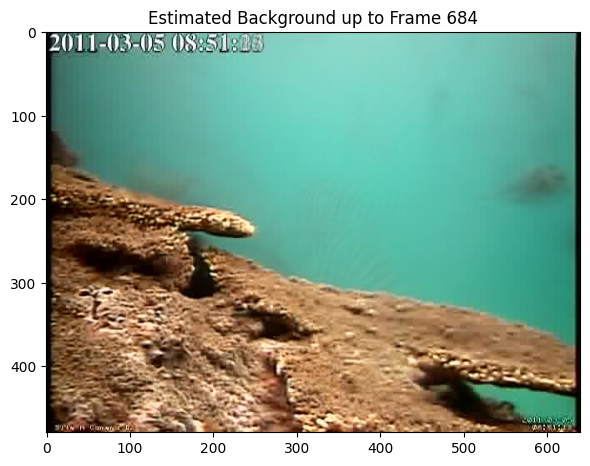

In [3]:
# Build a stable background via exponential running average
alpha = 0.99                # smoothing factor (↑α → slower adaptation)
start_frame = 2
end_frame = seq0[0]

for frame_num in range(start_frame, end_frame):
    # load and convert the current frame to float
    I = imread(os.path.join(vid_path, 'frame%04d.jpg'%frame_num))
    
    # update background estimate: B_t = α B_{t-1} + (1−α) I_t
    B = alpha*B + (1-alpha)*I

# visualize the converged background
plt.figure(figsize=(6, 6))
plt.imshow(B / 255.0)  # normalize from [0,255] → [0,1] for display
plt.title(f"Estimated Background up to Frame {end_frame-1}")
plt.tight_layout()
plt.show()

Difference map range: min=0.16, max=321.54


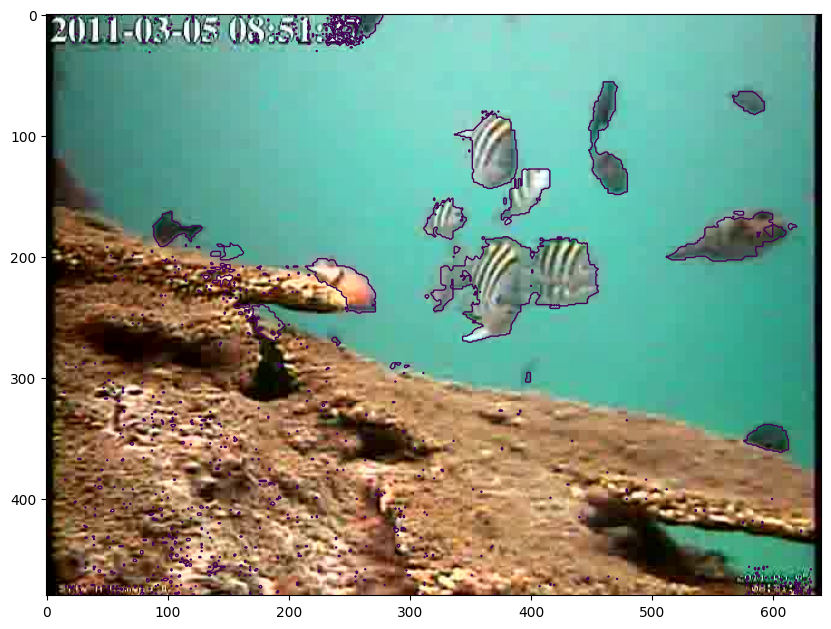

In [4]:
# compute difference map between current frame (I) and background (B)
F = np.sqrt(((I-B)**2).sum(axis=2))
print(f"Difference map range: min={F.min():.2f}, max={F.max():.2f}")

# threshold to obtain foreground mask
fg_mask = F>50

# visualize foreground contours over the original frame
plt.figure(figsize=(10,10))
plt.imshow(I)
plt.contour(fg_mask, linewidths=1)
plt.show()

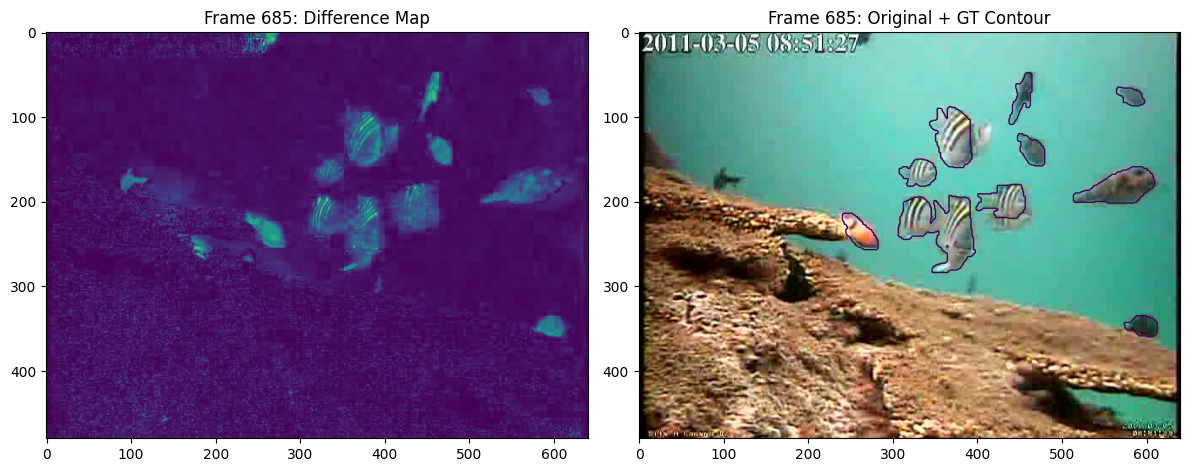

In [5]:
# compare estimated foreground (difference map) to ground truth for the first frame in seq0
for frame_id in range(*seq0):
    I = imread(os.path.join(vid_path, 'frame%04d.jpg'%frame_id)) # image
    F = np.sqrt(((I-B)**2).sum(axis=2)) # foreground estimation
    S = imread(os.path.join(gt_path, '%d.png'%frame_id))>0 # supervision (binary mask)

    # plot side-by-side: difference map vs. original frame with GT contour
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # left: raw difference map
    ax1.imshow(F)
    ax1.set_title(f'Frame {frame_id}: Difference Map')

    # right: original frame with ground-truth outline
    ax2.imshow(I)
    ax2.contour(S, linewidths=1.0)
    ax2.set_title(f'Frame {frame_id}: Original + GT Contour')

    plt.tight_layout()
    plt.show()
    break  # show only the first example for clarity

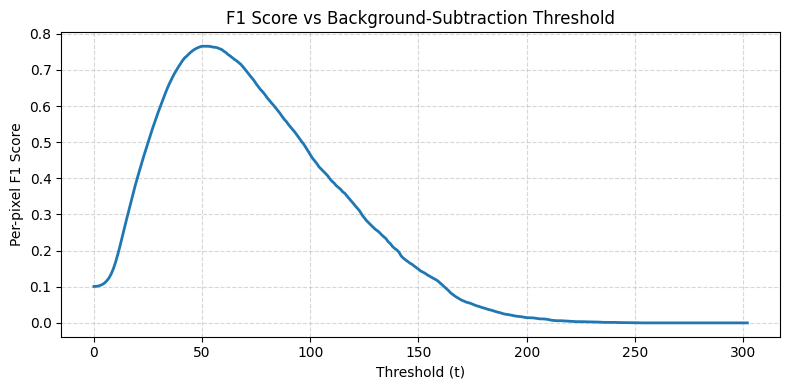

Optimal threshold: 50  →  F1 = 0.766


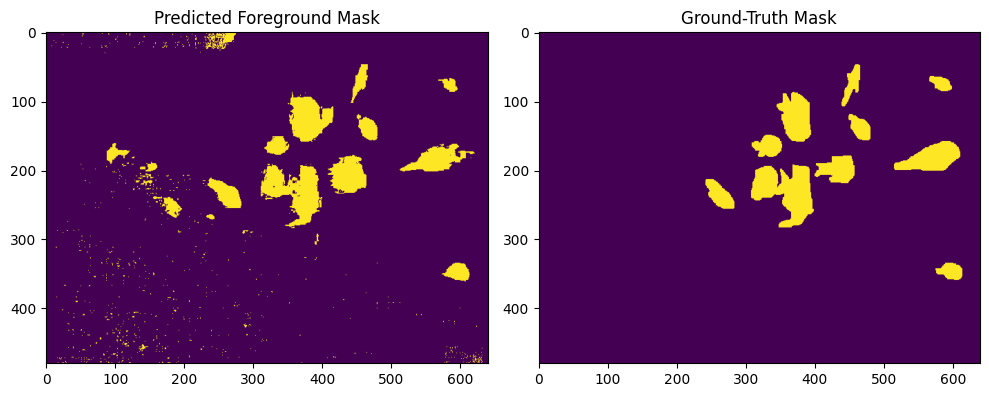

In [6]:
# F1 score function
def compute_f1_score(gt_mask, pred_mask):
    """
    Compute per-pixel F1 (Dice) between two boolean masks.
    """
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    return 2 * intersection / (gt_mask.sum() + pred_mask.sum())

# build F1 vs threshold curve
max_thresh = int(F.max())
thresholds = np.arange(max_thresh + 1)

f1_scores = []
for t in thresholds:
    # binary prediction at this threshold
    pred_mask = (F > t)
    f1_scores.append(compute_f1_score(S, pred_mask))

# plot the curve
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, lw=2)
plt.xlabel("Threshold (t)")
plt.ylabel("Per-pixel F1 Score")
plt.title("F1 Score vs Background-Subtraction Threshold")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# pick and report the best threshold
best_idx   = np.argmax(f1_scores)
best_score = f1_scores[best_idx]
print(f"Optimal threshold: {best_idx}  →  F1 = {best_score:.3f}")

# visualize final prediction vs ground truth
final_pred = (F > best_idx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(final_pred)
ax1.set_title("Predicted Foreground Mask")

ax2.imshow(S)
ax2.set_title("Ground-Truth Mask")

plt.tight_layout()
plt.show()

F1 after cleanup: 0.781


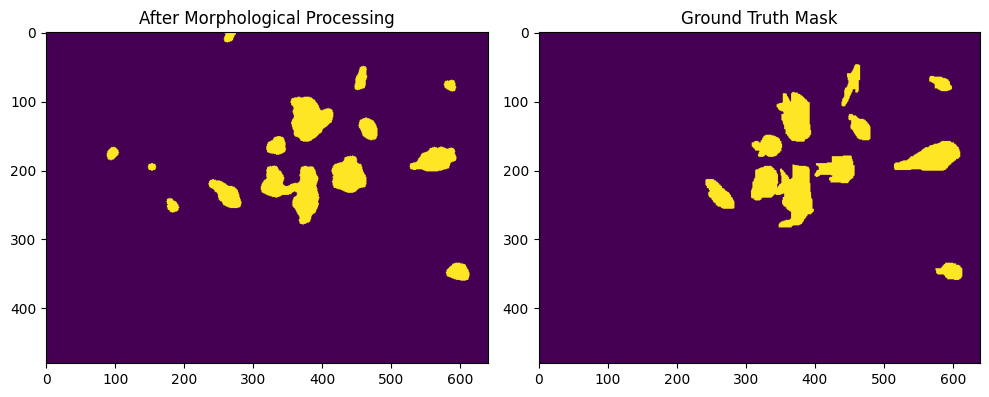

In [7]:
# there still some noise, we use morfological operations
# e.g. morfological opening to remove small objects in the backgroung or morfological closings to clean the inside of the objects
from skimage.morphology import opening, closing, disk

# remove small background speckles with a morphological opening
opened_mask = opening(final_pred, disk(5))

# fill small holes inside the detected objects with a closing
cleaned_mask = closing(opened_mask, disk(3))

# compute(F1) score against ground truth
f1_post = compute_f1_score(S, cleaned_mask)
print(f"F1 after cleanup: {f1_post:.3f}")

# visualize the cleaned mask side-by-side with the ground truth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(cleaned_mask)
ax1.set_title("After Morphological Processing")

ax2.imshow(S)
ax2.set_title("Ground Truth Mask")

plt.tight_layout()
plt.show()

# we can also match each object of the prediction with the object with max overlap in the supervision and say: if there's more 50% overlap it's a true positive detection

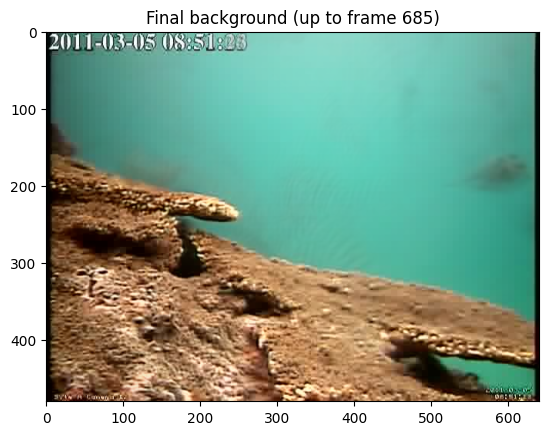

In [8]:
# Background estimation
vid_path = 'data/video_data/Video/'
gt_path = 'data/video_data/GroundTruth/'

seq0 = [685,705]
seq1 = [1173,1191]

B = imread(os.path.join(vid_path, 'frame%04d.jpg'%1))
for f in range(2, seq0[0]):
    I = imread(os.path.join(vid_path, 'frame%04d.jpg'%f))
    B = alpha*B + (1-alpha)*I

plt.figure()
plt.imshow(B/255)
plt.title(f"Final background (up to frame {seq0[0]})")
plt.show()

In [9]:
from scipy.ndimage import uniform_filter1d

# compute per-pixel Euclidean difference
def compute_F(I, B):
    return np.sqrt(((I.astype(float) - B)**2).sum(axis=2))

# optimize threshold over all frames in one GT interval
def optimize_seq(seq):
    start, end = seq
    # collect all diff‐maps
    F_list = []
    for f in range(start, end+1):
        I = imread(os.path.join(vid_path, 'frame%04d.jpg'%f))
        F_list.append(compute_F(I, B))
    # search 0..max(F)
    max_t = int(max(F.max() for F in F_list))
    avg_F1 = []
    for t in range(max_t+1):
        per_frame = []
        for idx, F in zip(range(start, end+1), F_list):
            S = imread(os.path.join(gt_path, '%d.png'%idx)) > 0
            P = F > t
            inter = (P & S).sum()
            per_frame.append(2*inter / (P.sum() + S.sum()))
        avg_F1.append(np.mean(per_frame))
    # mooth & pick best
    avg_F1_s = uniform_filter1d(avg_F1, size=5)
    t_opt = int(np.argmax(avg_F1_s))
    return t_opt, avg_F1, avg_F1_s

# find optima threshold for seq0 & seq1
t0, f1_0, f1s0 = optimize_seq(seq0)
t1, f1_1, f1s1 = optimize_seq(seq1)
print("Optimal thresholds → seq0:", t0, "  seq1:", t1)

Optimal thresholds → seq0: 52   seq1: 70


Global threshold: 61


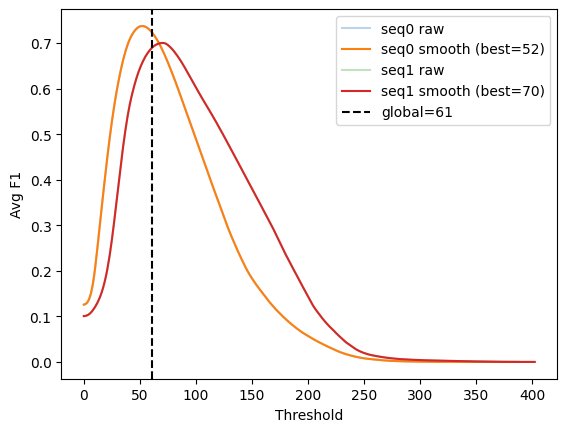

In [10]:
# global threshold as average of the two
t_global = int(round((t0 + t1)/2))
print("Global threshold:", t_global)

# plot raw vs smooth F1 curves
plt.figure()
plt.plot(f1_0, alpha=0.3, label='seq0 raw')
plt.plot(f1s0, label=f'seq0 smooth (best={t0})')
plt.plot(f1_1, alpha=0.3, label='seq1 raw')
plt.plot(f1s1, label=f'seq1 smooth (best={t1})')
plt.axvline(t_global, color='k', linestyle='--', label=f'global={t_global}')
plt.xlabel("Threshold"); plt.ylabel("Avg F1")
plt.legend()
plt.show()

In [11]:
# final segmentation and evaluation
for name, seq in zip(("seq0","seq1"), (seq0, seq1)):
    start, end = seq
    F1s = []
    for f in range(start, end+1):
        I = imread(os.path.join(vid_path, 'frame%04d.jpg'%f))
        F = compute_F(I, B)
        P = F > t_global            # use global or per‐seq threshold
        # morphological cleanup
        opened_mask = opening(P, disk(5))
        cleaned_mask = closing(opened_mask, disk(3))
        S = imread(os.path.join(gt_path, '%d.png'%f)) > 0
        inter = (cleaned_mask & S).sum()
        F1s.append(2*inter / (cleaned_mask.sum() + S.sum()))
    print(f"{name} mean F1: {np.mean(F1s):.3f}")

seq0 mean F1: 0.691
seq1 mean F1: 0.761


## Object tracking

1. Extract interesting features from the detected objects.
1. Suggest a method to recognise and track objects from one frame to the next frame.

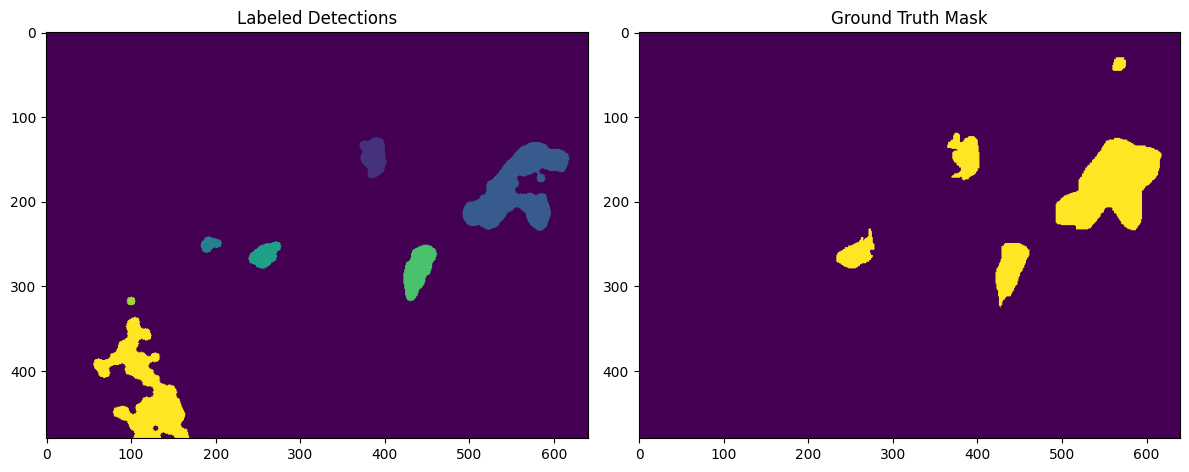

In [12]:
from skimage.measure import label

labels = label(cleaned_mask)

# display the labeled components alongside the ground truth mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(labels)
ax1.set_title("Labeled Detections")

ax2.imshow(S)
ax2.set_title("Ground Truth Mask")

plt.tight_layout()
plt.show()

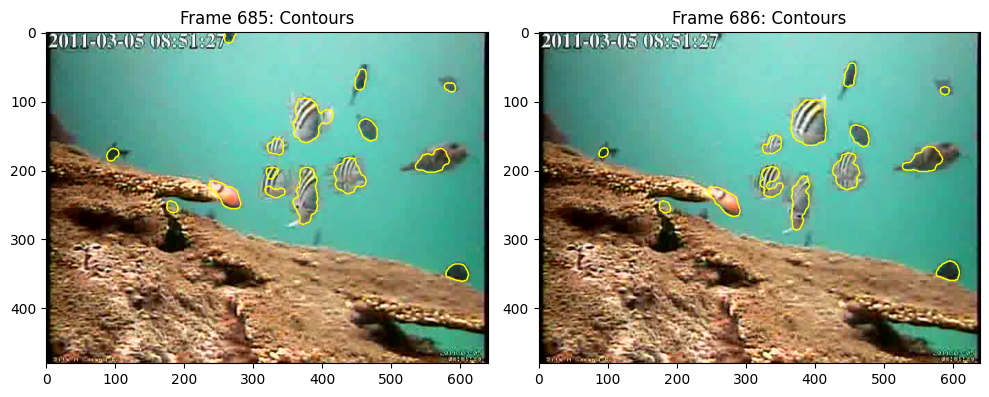

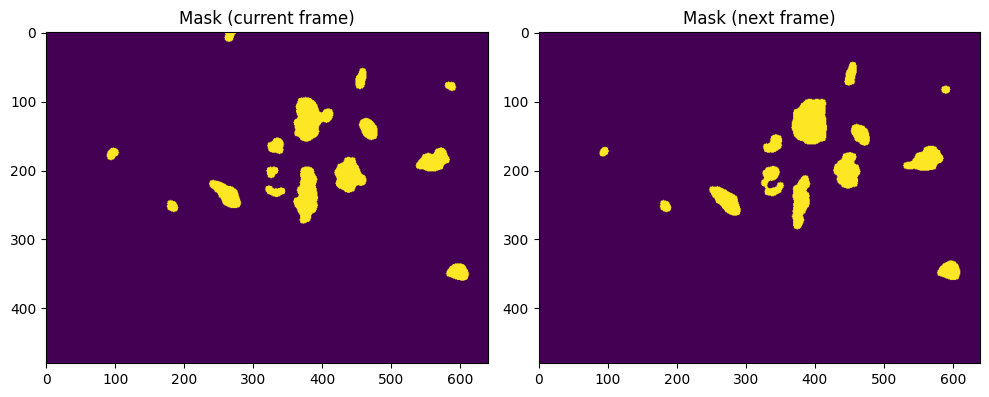

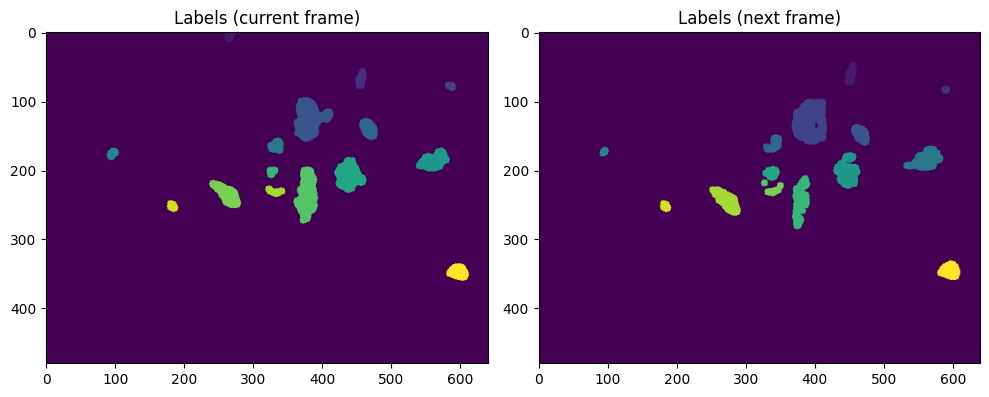

In [13]:
frame_id = 685
next_frame = frame_id + 1

# image
I = imread(os.path.join(vid_path, 'frame%04d.jpg'%frame_id))
I_next = imread(os.path.join(vid_path, 'frame%04d.jpg'%next_frame))

# foreground
F = compute_F(I, B)
F_next = compute_F(I_next, B)

# ground truth
S = imread(os.path.join(gt_path, '%d.png'%frame_id)) > 0
S_next = imread(os.path.join(gt_path, '%d.png'%next_frame))>0 # supervision (binary mask)

# binary masks + morphological cleanup
opened_mask = opening(F > t_global, disk(5))
cleaned_mask = closing(opened_mask, disk(3))
opened_mask_next = opening(F_next > t_global, disk(5))
cleaned_mask_next = closing(opened_mask_next, disk(3))

# label connected components
labels = label(cleaned_mask)
labels_next = label(opened_mask_next)

# visualization: original frames with contours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(I)
ax1.contour(cleaned_mask, colors='yellow', linewidths=1)
ax1.set_title(f"Frame {frame_id}: Contours")

ax2.imshow(I_next)
ax2.contour(cleaned_mask_next, colors='yellow', linewidths=1)
ax2.set_title(f"Frame {next_frame}: Contours")

plt.tight_layout()
plt.show()

# visualization: binary masks alone
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(cleaned_mask)
ax1.set_title("Mask (current frame)")

ax2.imshow(cleaned_mask_next)
ax2.set_title("Mask (next frame)")

plt.tight_layout()
plt.show()

# visualization: labeled components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(labels)
ax1.set_title("Labels (current frame)")

ax2.imshow(labels_next)
ax2.set_title("Labels (next frame)")

plt.tight_layout()
plt.show()

1 [0]


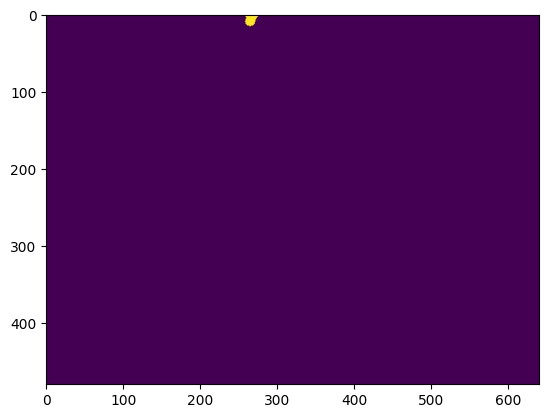

2 [0 1]


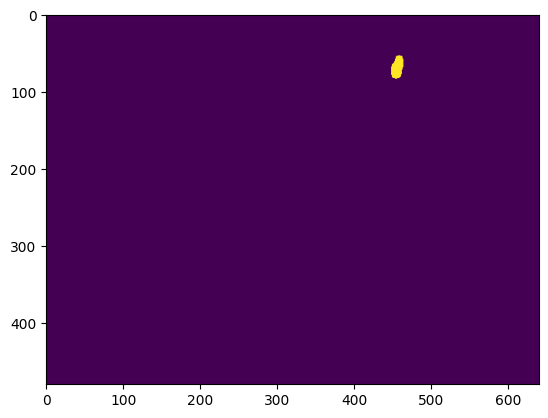

3 [0 2]


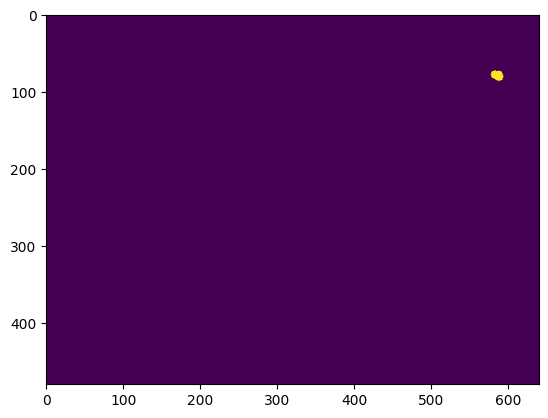

4 [0 3]


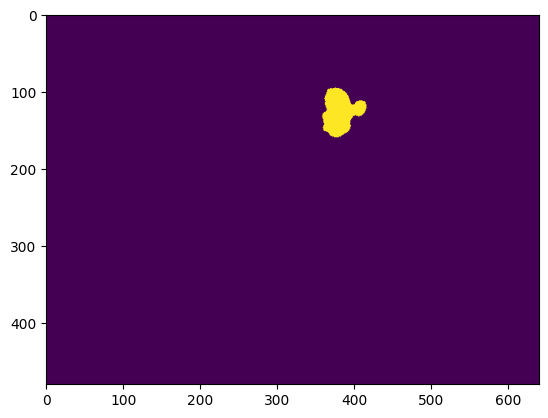

5 [0 4]


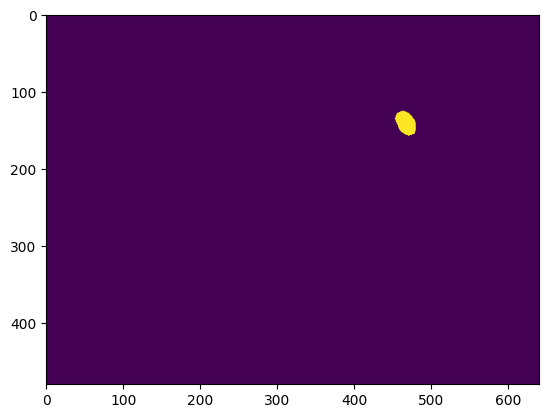

6 [0 5]


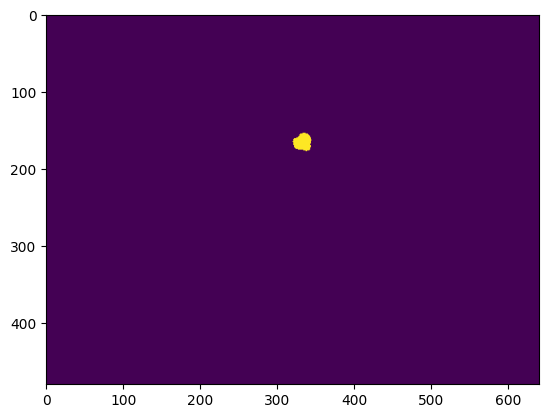

7 [0 7]


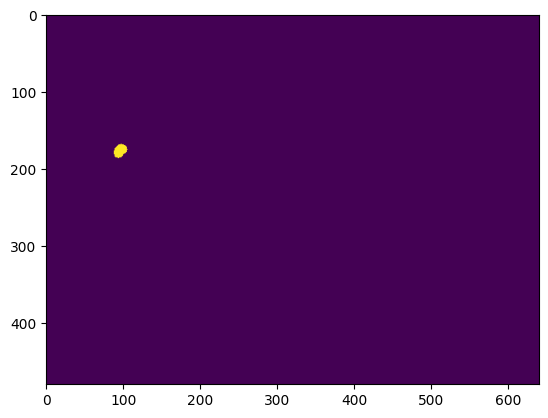

8 [0 6]


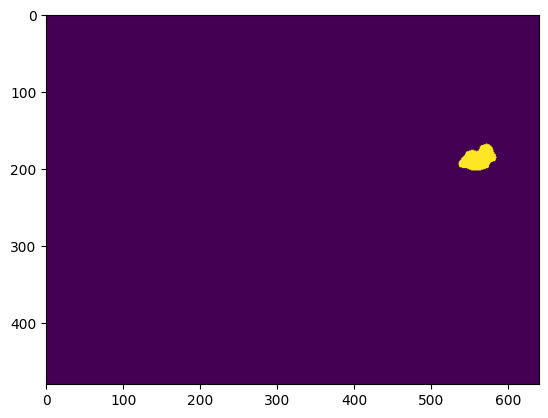

9 [0 8]


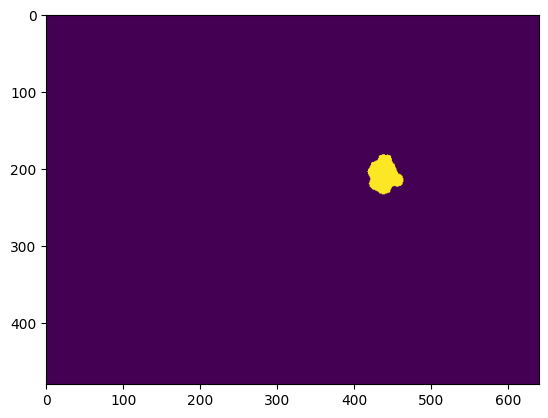

10 [0 9]


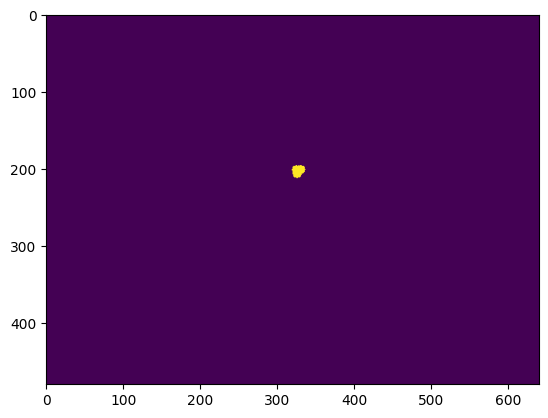

11 [ 0 10]


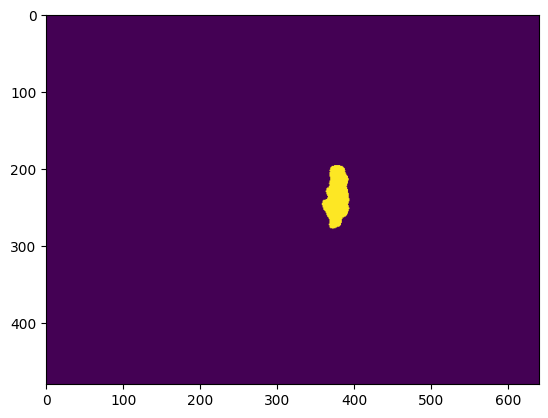

12 [ 0 13]


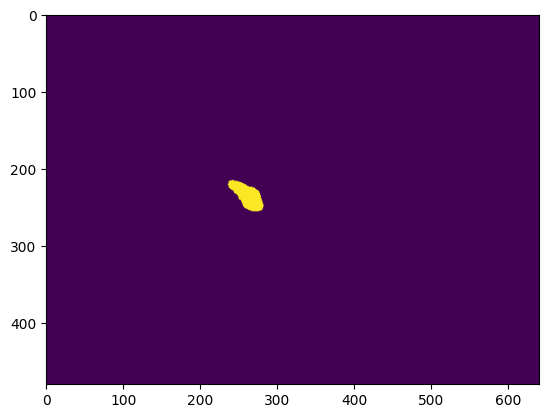

13 [ 0 11 12]


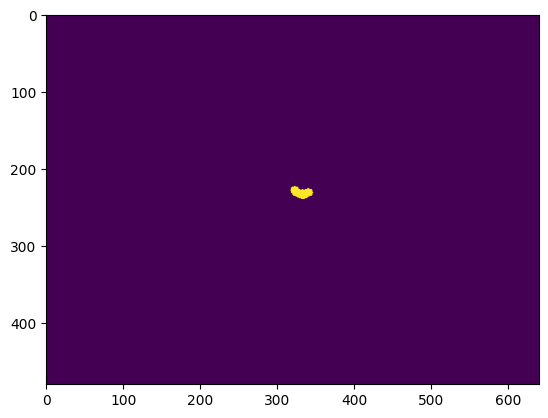

14 [ 0 14]


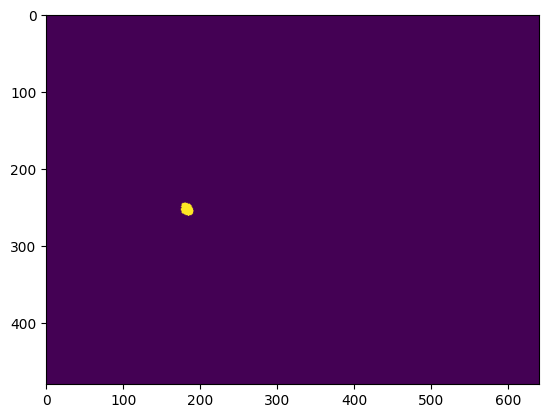

15 [ 0 15]


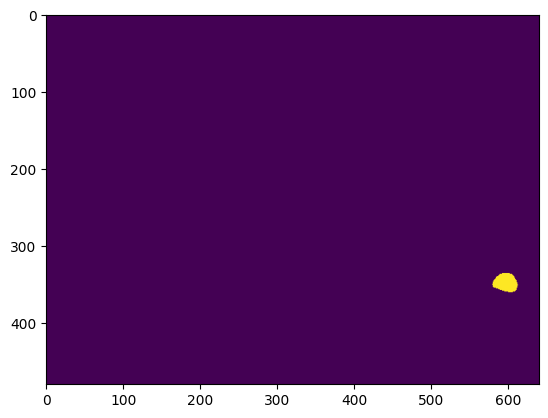

In [14]:
# Hypothesis: fish won't move much btw frames
# Find objects based on their closest match in terms of centroid distance

for lab in range(1, labels.max()+1): # labels will be 0 for background and then going from 1 to n of objects
    matching_objects = np.unique(labels_next[labels==lab])
    print(lab, matching_objects)
    plt.figure()
    plt.imshow(labels==lab)
    plt.show()

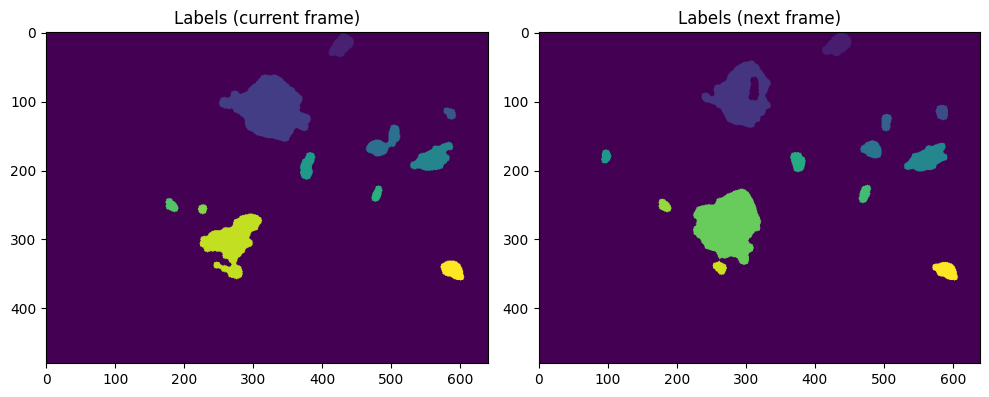

In [17]:
frame_id = seq0[0] + 10
next_frame = frame_id + 1

# image frames
I = imread(os.path.join(vid_path, f'frame{frame_id:04d}.jpg'))
I_next = imread(os.path.join(vid_path, f'frame{next_frame:04d}.jpg'))

# foreground estimation (difference from background)
F = compute_F(I, B)
F_next = compute_F(I_next, B)

# ground‐truth masks
S = imread(os.path.join(gt_path, f'{frame_id}.png')) > 0
S_next = imread(os.path.join(gt_path, f'{next_frame}.png')) > 0

# binary masks + morphological cleanup
opened_mask = opening(F > t_global, disk(5))
cleaned_mask = closing(opened_mask, disk(3))
opened_mask_next = opening(F_next > t_global, disk(5))
cleaned_mask_next = closing(opened_mask_next,  disk(3))

# label connected components
labels = label(cleaned_mask,       connectivity=2)
labels_next = label(cleaned_mask_next,  connectivity=2)

# visualization: original frames with contours
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(labels)
ax1.set_title("Labels (current frame)")

ax2.imshow(labels_next)
ax2.set_title("Labels (next frame)")

plt.tight_layout()
plt.show()

In [18]:
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

frame_id = seq0[0] + 10
next_frame = frame_id + 1

# image
I = imread(os.path.join(vid_path, f'frame{frame_id:04d}.jpg'))

# foreground estimation
F = compute_F(I, B)

# morphological cleanup
mask = opening(F > t_global, disk(5))
cleaned_mask = closing(mask, disk(3))

# label connected components
labels = label(cleaned_mask, connectivity=2)

# Frame t+1
I_next = imread(os.path.join(vid_path, f'frame{next_frame:04d}.jpg'))
F_next = compute_F(I_next, B)
mask_next = opening(F_next > t_global, disk(5))
cleaned_mask_next = closing(mask_next, disk(3))
labels_next = label(cleaned_mask_next, connectivity=2)

# feature extraction function
def extract_features(image, labels):
    props = regionprops(labels, intensity_image=image)
    feats = []
    for p in props:
        feats.append({
            'label':      p.label,
            'centroid':   np.array(p.centroid),
            'area':       p.area,
            'mean_color': image[p.coords[:,0], p.coords[:,1]].mean(axis=0)
        })
    return feats

# extract features from both frames
feats_t   = extract_features(I,       labels)
feats_t2  = extract_features(I_next,  labels_next)

# Cost = Euclidean distance between centroids
C = cdist(
    np.vstack([f['centroid'] for f in feats_t]),
    np.vstack([f['centroid'] for f in feats_t2])
)

row_idx, col_idx = linear_sum_assignment(C)

print("Matches (frame t → frame t+1):")
for i, j in zip(row_idx, col_idx):
    lbl1 = feats_t[i]['label']
    lbl2 = feats_t2[j]['label']
    dist = C[i, j]
    print(f"  object {lbl1} → object {lbl2}, centroid dist = {dist:.1f}")

Matches (frame t → frame t+1):
  object 1 → object 1, centroid dist = 4.9
  object 2 → object 2, centroid dist = 35.7
  object 3 → object 3, centroid dist = 1.9
  object 4 → object 5, centroid dist = 12.7
  object 5 → object 6, centroid dist = 1.6
  object 6 → object 8, centroid dist = 7.3
  object 7 → object 9, centroid dist = 7.6
  object 8 → object 11, centroid dist = 0.5
  object 9 → object 10, centroid dist = 53.3
  object 10 → object 12, centroid dist = 37.2
  object 11 → object 13, centroid dist = 0.9


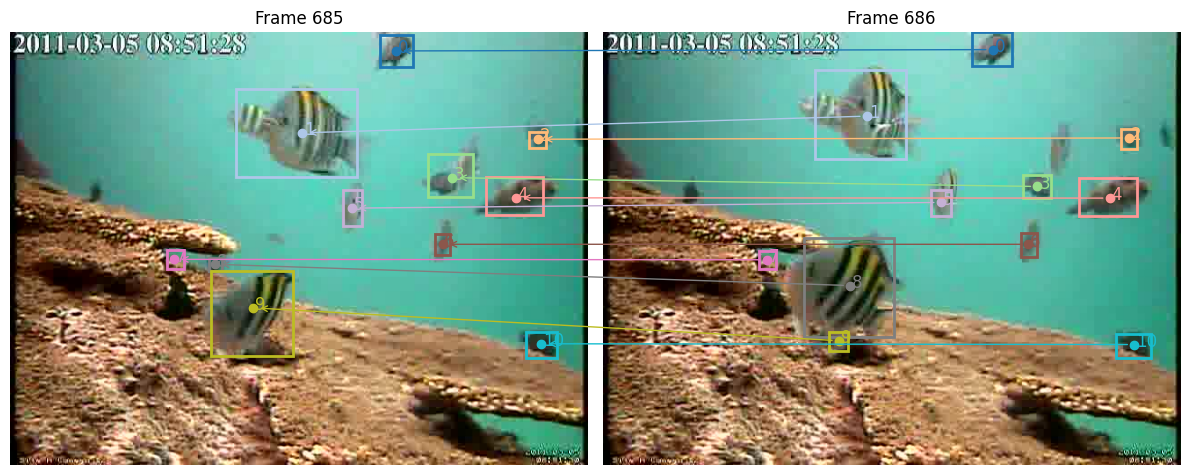

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, ConnectionPatch
from skimage.measure import regionprops

# Get regionprops for bounding boxes & centroids
props_t  = {p.label: p for p in regionprops(labels, intensity_image=I)}
props_t2 = {p.label: p for p in regionprops(labels_next, intensity_image=I_next)}

# Choose a colormap with enough distinct colors
cmap = plt.get_cmap('tab20')
n_matches = len(row_idx)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.imshow(I);  ax1.set_title(f'Frame {start_frame}');  ax1.axis('off')
ax2.imshow(I_next); ax2.set_title(f'Frame {start_frame+1}'); ax2.axis('off')

for k, (i, j) in enumerate(zip(row_idx, col_idx)):
    col = cmap(k / n_matches)
    lab1 = feats_t[i]['label']
    lab2 = feats_t2[j]['label']
    
    # Draw bbox on frame t
    p1 = props_t[lab1]
    minr1, minc1, maxr1, maxc1 = p1.bbox
    rect1 = Rectangle((minc1, minr1), maxc1-minc1, maxr1-minr1,
                      fill=False, edgecolor=col, linewidth=2)
    ax1.add_patch(rect1)
    # centroid marker + ID
    cy1, cx1 = p1.centroid
    ax1.plot(cx1, cy1, 'o', color=col)
    ax1.text(cx1+2, cy1+2, str(k), color=col, fontsize=12)

    # Draw bbox on frame t+1
    p2 = props_t2[lab2]
    minr2, minc2, maxr2, maxc2 = p2.bbox
    rect2 = Rectangle((minc2, minr2), maxc2-minc2, maxr2-minr2,
                      fill=False, edgecolor=col, linewidth=2)
    ax2.add_patch(rect2)
    # centroid marker + ID
    cy2, cx2 = p2.centroid
    ax2.plot(cx2, cy2, 'o', color=col)
    ax2.text(cx2+2, cy2+2, str(k), color=col, fontsize=12)

    # Draw arrow connecting centroids across the two axes
    con = ConnectionPatch(
        xyA=(cx2, cy2), coordsA=ax2.transData,
        xyB=(cx1, cy1), coordsB=ax1.transData,
        arrowstyle='->', shrinkA=5, shrinkB=5, color=col, linewidth=1
    )
    fig.add_artist(con)

plt.tight_layout()
plt.show()

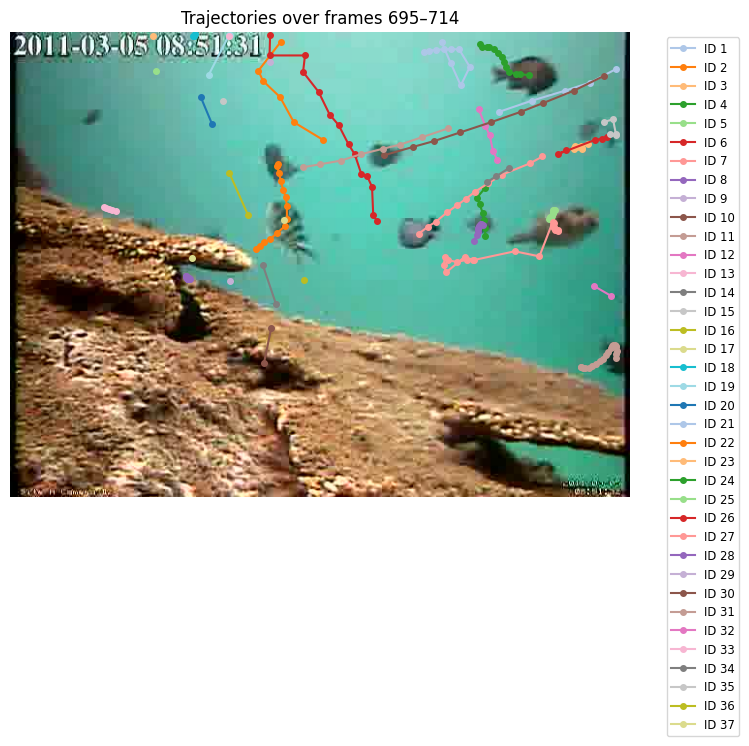

In [76]:
# params
start_frame = seq0[0] + 10   # e.g. 695
n_frames = 20
t_thresh = t_global
bg_disk = 5
obj_disk = 3

def compute_F(I, B):
    return np.sqrt(((I.astype(float) - B)**2).sum(axis=2))

def segment_frame(f):
    I = imread(os.path.join(vid_path, f'frame{f:04d}.jpg'))
    F = compute_F(I, B)
    open_mask = opening(F > t_thresh, disk(bg_disk))
    cleaned_mask = closing(open_mask, disk(obj_disk))
    lbl = label(cleaned_mask)
    return I, lbl

def extract_feats(I, lbl):
    props = regionprops(lbl, intensity_image=I[:,:,0])  
    feats = []
    for p in props:
        feats.append({
            'label':    p.label,
            'centroid': np.array(p.centroid),
            'bbox':     p.bbox
        })
    return feats

# initialize first frame
# segment & extract features
I_prev, lbl_prev = segment_frame(start_frame)
feats_prev = extract_feats(I_prev, lbl_prev)

# assign each detection its own track_id
next_track_id = 1
for feat in feats_prev:
    feat['track_id'] = next_track_id
    next_track_id   += 1

# Store trajectories: track_id -> list of centroids
trajectories = {feat['track_id']: [feat['centroid']] 
                for feat in feats_prev}

# Loop through the next frames
for dt in range(1, n_frames):
    f_curr = start_frame + dt
    I_curr, lbl_curr = segment_frame(f_curr)
    feats_curr       = extract_feats(I_curr, lbl_curr)

    # build cost = Euclidean distance between centroids
    C = cdist(
        np.vstack([f['centroid'] for f in feats_prev]),
        np.vstack([f['centroid'] for f in feats_curr])
    )
    row, col = linear_sum_assignment(C)

    assigned = set()
    # match old→new
    for i_prev, j_curr in zip(row, col):
        dist = C[i_prev, j_curr]
        # optionally skip matches that are too far
        if dist < 50:  
            track_id = feats_prev[i_prev]['track_id']
            feats_curr[j_curr]['track_id'] = track_id
            trajectories[track_id].append(feats_curr[j_curr]['centroid'])
            assigned.add(j_curr)

    # any unmatched current detections → new tracks
    for k, feat in enumerate(feats_curr):
        if k not in assigned:
            feat['track_id'] = next_track_id
            trajectories[next_track_id] = [feat['centroid']]
            next_track_id += 1

    # move on
    feats_prev = feats_curr
    lbl_prev   = lbl_curr

# Visualize trajectories overlaid on the last frame
plt.figure(figsize=(8,8))
plt.imshow(I_curr)
cmap = plt.get_cmap('tab20')

for tidx, (track_id, points) in enumerate(trajectories.items()):
    pts = np.array(points)
    color = cmap((track_id % cmap.N) / cmap.N)
    plt.plot(pts[:,1], pts[:,0], '-o', color=color, ms=4, label=f'ID {track_id}')

plt.title(f"Trajectories over frames {start_frame}–{start_frame+n_frames-1}")
plt.axis('off')
plt.legend(bbox_to_anchor=(1.05,1), fontsize='small')
plt.show()